<a href="https://colab.research.google.com/github/fernandolievano/ProyectoFinal_PP1/blob/entrega-final%2Fparcial-2/ProyectoFinal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 # 1. Introducción

In [1]:
# @title
from urllib.request import urlopen
from IPython.display import HTML

RAW_URL = "https://raw.githubusercontent.com/fernandolievano/ProyectoFinal_PP1/main/assets/doc.html"
with urlopen(RAW_URL) as f:
    html = f.read().decode("utf-8", errors="replace")
HTML(html)

# 2. Configuración del entorno

### 2.1 Instalación de Librerías

In [126]:
%pip install pandas numpy plotly seaborn bokeh

### 2.2 Importación de Módulos

In [127]:
import pandas as pd
import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from bokeh.plotting import figure, show, output_file
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter, Slope
from bokeh.transform import transform
from bokeh.layouts import gridplot
from bokeh.palettes import RdBu11, Category10
from sklearn.linear_model import LinearRegression



# Configuraciones
sns.set(rc={'axes.facecolor':'black', 'axes.labelcolor': 'white', 'figure.facecolor':'black', 'text.color': 'white', 'xtick.color': 'white',
 'ytick.color': 'white',})

# formato de floats
pd.options.display.float_format = '{:,.2f}'.format

### 2.3 Carga del Dataset

In [4]:
dataset_url = "https://raw.githubusercontent.com/fernandolievano/ProyectoFinal_PP1/main/data/stack-overflow-developer-survey-2025.csv.gz"
df = pd.read_csv(dataset_url, compression='gzip')

print("✅ DataSet cargado con éxto")

✅ DataSet cargado con éxto


### 2.4 Funciones y Variables Utilitarias

In [5]:
# Funciones Reutilizables
def contar_valores_explodidos(dataframe, columna, separador):
    """
    Cuenta las incidencias de valores en una columna que contiene strings
    separados por un delimitador.
    """
    if columna not in dataframe.columns:
        raise ValueError(f"Columna {columna} no encontrada")

    return (dataframe[columna]
            .str.split(separador)
            .explode()  # cada elemento de la lista se vuelve una fila
            .value_counts())

# Variables Iniciales
n_encuestados = len(df)
print(f"👥 Número incial de encuestados: {n_encuestados}")

👥 Número incial de encuestados: 49123


# 3. Exploración Inicial del Dataset

### 3.1 Estructura y Dimensiones

In [6]:
print(f"Dimensiones del Dataset: {df.shape}")
print(f"Número de filas: {df.shape[0]}")
print(f"Número de columnas: {df.shape[1]}")

Dimensiones del Dataset: (49123, 170)
Número de filas: 49123
Número de columnas: 170


### 3.2 Información general del Dataset

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49123 entries, 0 to 49122
Columns: 170 entries, ResponseId to JobSat
dtypes: float64(50), int64(1), object(119)
memory usage: 63.7+ MB


### 3.3 Head y Tail para muestras

In [8]:
df.head()

,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
0,1,I am a developer by profession,25-34 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",Employed,"Caring for dependents (children, elderly, etc.)",8.00,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,Vertex AI,NaN,NaN,NaN,ChatGPT,NaN,When I don’t trust AI’s answers,"Troubleshooting, profiling, debugging","61,256.00",10.00
1,2,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,NaN,2.00,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers;When I want to...,All skills. AI is a flop.,"104,413.00",9.00
2,3,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Independent contractor, freelancer, or self-em...",None of the above,10.00,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code;GitHub Copilot;Google Gemini,NaN,When I don’t trust AI’s answers;When I want to...,"Understand how things actually work, problem s...","53,061.00",8.00
3,4,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,None of the above,4.00,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,ChatGPT;Claude Code,NaN,When I don’t trust AI’s answers;When I want to...,NaN,"36,197.00",6.00
4,5,I am a developer by profession,35-44 years old,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...","Caring for dependents (children, elderly, etc.)",21.00,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,When I don’t trust AI’s answers,"critical thinking, the skill to define the tas...","60,000.00",7.00


In [9]:
df.tail()

,ResponseId,MainBranch,Age,EdLevel,Employment,EmploymentAddl,WorkExp,LearnCodeChoose,LearnCode,LearnCodeAI,...,AIAgentOrchestration,AIAgentOrchWrite,AIAgentObserveSecure,AIAgentObsWrite,AIAgentExternal,AIAgentExtWrite,AIHuman,AIOpen,ConvertedCompYearly,JobSat
49118,49119,I am a developer by profession,25-34 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,NaN,9.00,"Yes, I am not new to coding but am learning ne...",Online Courses or Certification (includes all ...,"Yes, I learned how to use AI-enabled tools req...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00
49119,49120,I am a developer by profession,35-44 years old,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed,"Caring for dependents (children, elderly, etc.)",13.00,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools req...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49120,49121,I am a developer by profession,25-34 years old,"Secondary school (e.g. American high school, G...",Employed,NaN,2.00,"Yes, I am not new to coding but am learning ne...","Other online resources (e.g. standard search, ...","No, I didn't spend time learning in the past year",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49121,49122,I am a developer by profession,25-34 years old,"Associate degree (A.A., A.S., etc.)",Employed,None of the above;Engaged in paid work (20-29 ...,10.00,"No, I am not new to coding and did not learn n...",NaN,"Yes, I learned how to use AI-enabled tools for...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.00
49122,49123,I am a developer by profession,25-34 years old,Some college/university study without earning ...,Employed,None of the above,10.00,"No, I am not new to coding and did not learn n...",NaN,"No, I learned something that was not related t...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.00


# 4. Análisis Exploratorio de Datos (EDA)
Llevaremos a cabo un análisis exploratorio de datos utilizando visualizaciones interactivas y estadísticas descriptivas, con el objetivo de comprender mejor los resultados de la encuesta hecha por Stack Overflow en 2025. Mediante este proceso podremos responder preguntas sobre lenguajes de programación más usados, tecnologías en tendencias, roles comunes y niveles salariales.

### 4.1 Verificación de nulos

In [10]:
pd.set_option('display.max_rows', None)  # Activo display.max_rows para poder ver todos mis columnas nulas

tiene_nulos = df.isnull().sum() > 0  # Máscara para mostrar solo resultados con valores nulos
nulos = df.isnull().sum()[tiene_nulos]
nulos_cantidad = len(nulos)
nulos_porcentaje = (nulos / n_encuestados) * 100

print(f"❗ Encontramos {nulos_cantidad} columnas con datos nulos")

nulos_resumen = pd.DataFrame({
    'Tipo de Dato': df.dtypes[tiene_nulos],
    'Valores Nulos': nulos,
    '% Nulos': nulos_porcentaje
})

nulos_resumen

❗ Encontramos 167 columnas con datos nulos


,Tipo de Dato,Valores Nulos,% Nulos
EdLevel,object,1036,2.11
Employment,object,846,1.72
EmploymentAddl,object,4303,8.76
WorkExp,float64,6279,12.78
LearnCodeChoose,object,2322,4.73
LearnCode,object,15607,31.77
LearnCodeAI,object,3970,8.08
AILearnHow,object,20899,42.54
YearsCode,float64,6123,12.46
DevType,object,5487,11.17


In [11]:
pd.reset_option('display.max_rows', None)  # Desactivo de nuevo display.max_rows

### 4.2 Variables con Alto Porcentaje de Nulos

En este gráfico se muestran las variables con mayor porcentaje de valores faltantes.
Dado que superan ampliamente el 80% de nulos, pueden considerarse prescindibles para el análisis, ya que su nivel de completitud es insuficiente para obtener insights confiables.

In [12]:
sobre_80_porciento = nulos_porcentaje > 80  # Máscara obtener resultados mayores a 80%
nulos_altos = nulos_porcentaje[sobre_80_porciento].sort_values(ascending=False)

# Gráfico
fig_altos_nulos = px.bar(
    nulos_altos,
    color='value',
    orientation='h',
    title='⚠️ Variables con más del 80% de valores nulos',
    labels={'value': 'Porcentaje de Nulos', 'index': 'Variable'},
    color_continuous_scale='Reds'
)
fig_altos_nulos.update_layout(
    height=40 * len(nulos_altos),
    font=dict(
        size=14,
        color='#fff',
    ),
    title=dict(
        xanchor='center',
        x=0.5
    ),
    paper_bgcolor='black',
    plot_bgcolor='black',
)
fig_altos_nulos.show()

### 4.3 Variables Clave y su Completitud
Se muestran variables fundamentales del análisis (como país, educación y años de experiencia) que presentan un bajo porcentaje de valores faltantes, lo que permite tratarlos sin afectar la calidad de los resultados.

In [13]:
variables_clave = ['Country', 'Employment', 'EdLevel', 'WorkExp', 'YearsCode', 'ConvertedCompYearly']
nulos_claves = nulos_porcentaje[variables_clave].sort_values(ascending=False)

# Gráfico
fig_nulos_clave = px.bar(
    nulos_claves,
    title='🔑 Porcentaje de nulos en variables clave',
    labels={'value': 'Porcentaje de Nulos', 'index': 'Variable'},
    color='value',
    color_continuous_scale='sunsetdark'
)
fig_nulos_clave.update_layout(
    font=dict(
        size=14,
        color='#fff',
    ),
    title=dict(
        xanchor='center',
        x=0.5
    ),
    paper_bgcolor='black',
    plot_bgcolor='black',
)
fig_nulos_clave.show()

### 4.4 Manejo y Tratamiento de datos

In [14]:
# Creamos una copia del Dataset para el tratamiento de los datos
df_original = df.copy()
df_limpio = df.copy()
print(f"📊 Tamaño inicial del dataset: {df_limpio.shape}")

# LIMPIEZA DE DATOS 🧹
# Intentamos mantener solo las columnas relevantes para el análisis
columnas_a_mantener = ['Country', 'Employment', 'EdLevel', 'WorkExp', 'YearsCode',
                      'ConvertedCompYearly', 'LanguageHaveWorkedWith', 'LanguageWantToWorkWith']
df_limpio = df_limpio[columnas_a_mantener]
print("🗑️ Eliminadas columnas no utilizadas para el análisis")

# TRATAMIENTO DE NULOS
# Variables categóricas - mantenemos nulos como "No especificado"
categoricas_clave = ["Country", "Employment", "EdLevel"]
for col in categoricas_clave:
    df_limpio[col] = df_limpio[col].fillna('No especificado')
    print(f"✅ {col}: nulos convertidos a 'No especificado'")
# Variables numéricas - realizamos imputación simple
df_limpio['WorkExp'] = df_limpio['WorkExp'].fillna(df_limpio['WorkExp'].median())
df_limpio['YearsCode'] = df_limpio['YearsCode'].fillna(df_limpio['YearsCode'].median())
print("📈 Variables numéricas WorkExp y YearsCode: nulos imputados con mediana")
# Variable salario - eliminamos nulos
filas_antes = len(df_limpio)
df_limpio = df_limpio.dropna(subset=['ConvertedCompYearly'])
filas_eliminadas = filas_antes - len(df_limpio)
# Variable de lenguajes de programación - imputamos
df_limpio['LanguageHaveWorkedWith'] = df_limpio['LanguageHaveWorkedWith'].fillna('No especificado')
df_limpio['LanguageWantToWorkWith'] = df_limpio['LanguageWantToWorkWith'].fillna('No especificado')

print(f"- Tamaño final del dataset: {df_limpio.shape}")
print(f"- Porcentaje de datos conservados: {len(df_limpio)/len(df)*100:.1f}%")

# Reemplazamos el dataset principal con la versión limpia
df = df_limpio
print("✅ Dataset principal actualizado con datos tratados")

# Actualizamos la variable global de número de encuestados
# y la variable de cantidad de nulos
n_encuestados = len(df)
print(f"👥 Número de encuestados actualizados: {n_encuestados}")
# Verificación rápida post tratamiento de datos
print(f"🔍 Nulos restantes en el dataset: {df.isnull().sum().sum()}")


📊 Tamaño inicial del dataset: (49123, 170)
🗑️ Eliminadas columnas no utilizadas para el análisis
✅ Country: nulos convertidos a 'No especificado'
✅ Employment: nulos convertidos a 'No especificado'
✅ EdLevel: nulos convertidos a 'No especificado'
📈 Variables numéricas WorkExp y YearsCode: nulos imputados con mediana
- Tamaño final del dataset: (23928, 8)
- Porcentaje de datos conservados: 48.7%
✅ Dataset principal actualizado con datos tratados
👥 Número de encuestados actualizados: 23928
🔍 Nulos restantes en el dataset: 0


### 4.5 Estadísticas Descriptivas

4.5.1 Resúmenes numéricos de variables continuas

In [15]:
print("📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS")
variables_numericas = ['ConvertedCompYearly', 'WorkExp', 'YearsCode']
df_numericas = df[variables_numericas]

print(df_numericas.describe())

📊 ESTADÍSTICAS DESCRIPTIVAS - VARIABLES NUMÉRICAS
       ConvertedCompYearly   WorkExp  YearsCode
count            23,928.00 23,928.00  23,928.00
mean            101,791.60     13.63      17.69
std             461,934.47     10.04      11.04
min                   1.00      1.00       1.00
25%              38,171.00      6.00       9.00
50%              75,383.50     11.00      15.00
75%             120,630.25     20.00      25.00
max          50,000,000.00    100.00     100.00


4.5.2 Análisis de Correlacionales

In [16]:
matriz_de_correlacionales = df_numericas.corr()
matriz = matriz_de_correlacionales.round(2)

fig = px.imshow(
    matriz,
    text_auto=True,
    aspect="auto",
    color_continuous_scale=[
        "#2b2d42",
        "#3a506b",
        "#5bc0be",
        "#f4fffd",
        "#ff7b72",
        "#d90429"
    ]
)

fig.update_layout(
    title="📊 Matriz de Correlación entre Variables Numéricas",
    title_font_size=20,
    paper_bgcolor="black",
    plot_bgcolor="black",
    font=dict(color="white", size=14),
    margin=dict(l=40, r=40, t=80, b=40)
)

# Estilos colorbar
fig.update_coloraxes(
    colorbar=dict(
        thickness=15,
        tickcolor="white",
        tickfont=dict(color="white"),
        outlinewidth=0,
        bgcolor="rgba(0,0,0,0)"
    )
)

# Hover personalizado
fig.update_traces(
    hovertemplate="<b>%{x} ↔️  %{y}</b><br>"+
                  "Correlación: <b>%{z}</b><extra></extra>"
)

fig.show()


### 4.6 Análisis visual Multidimensional
En esta sección abordaremos un analisis multidimensional de nuestras variables e implementaremos diferentes herramientas y técnicas vistas durante la clase, como el uso de las librerías ***seaborn*** y ***bokeh***

4.6.1 Distribución de experiencia laboral - Seaborn

Text(0, 0.5, 'Frecuencia')

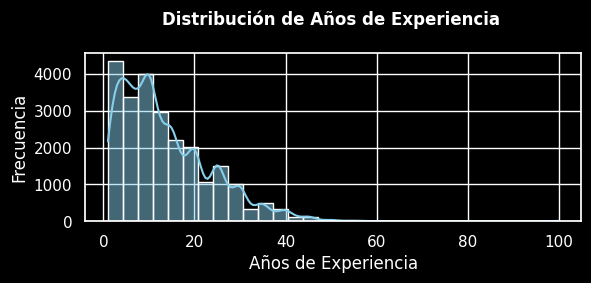

In [42]:
plt.subplot(2, 1, 1)
sns.histplot(data=df, x='WorkExp', bins=30, kde=True, color='skyblue')
plt.title('Distribución de Años de Experiencia \n', fontweight='bold')
plt.xlabel('Años de Experiencia')
plt.ylabel('Frecuencia')

4.6.2 Lenguajes más usados (top 10) - Bokeh

In [70]:
lenguajes_top_bokeh = contar_valores_explodidos(df, 'LanguageHaveWorkedWith', ';').head(10).sort_values(ascending=True)

p1 = figure(y_range=lenguajes_top_bokeh.index.tolist(),
           height=500,
           width=900,
           title="Lenguajes Más Utilizados - Bokeh",
           toolbar_location="above",
           background_fill_color="black",
           border_fill_color="black")

p1.hbar(y=lenguajes_top_bokeh.index.tolist(),
        right=lenguajes_top_bokeh.values.tolist(),
        height=0.7,
        color=Category10[10][:len(lenguajes_top_bokeh)],
        alpha=0.7)

p1.x_range.start = 0
p1.xaxis.axis_label = "Número de Desarrolladores"
p1.yaxis.axis_label = "Lenguajes"

hover1 = HoverTool()
hover1.tooltips = [
    ("Lenguaje", "@y"),
    ("Usuarios", "@right{0,0}"),
]
p1.add_tools(hover1)

output_file("plot.html")
show(p1)

 # 5. Análisis de hipótesis
 En esta sección se abordan las preguntas planteadas al inicio del proyecto, utilizando gráficos interactivos y resúmenes numéricos para explorarlas en detalle.

### 5.1 ¿Qué lenguajes de programación están en auge?

In [18]:
# Usamos la función "contar_valores_explodidos" para dividir los valores
# de la columna 'LanguageHaveWorkedWith' (separados por ';') y obtener
# un conteo de los lenguajes más utilizados.
lenguajes_usados_exploded = contar_valores_explodidos(dataframe=df, columna='LanguageHaveWorkedWith', separador=';')
lenguajes_usados_exploded = lenguajes_usados_exploded.sort_values(ascending=True)

fig_lenguajes_usados = px.bar(
    lenguajes_usados_exploded,
    title='👨‍💻 Lenguajes de programación más utilizados en 2025',
    color='value',
    color_continuous_scale='pinkyl',
    orientation='h',
    labels={'value': 'Uso', 'LanguageHaveWorkedWith': 'Lenguaje de Programación'},
)
fig_lenguajes_usados.update_layout(
    font=dict(
        size=14,
        color='#fff',
    ),
    paper_bgcolor='black',
    plot_bgcolor='black',
    height=36 * len(lenguajes_usados_exploded),
    title=dict(
        xanchor='center',
        x=0.5
    ),
)

fig_lenguajes_usados.show()

> 🔍 **El ecosistema web domina el uso**. JavaScript, HTML/CSS y SQL lideran con Python muy cerca. Además, TypeScript se posiciona por encima de Java/C#, evidenciando la consolidación del front-end “profesional”.

In [19]:
# === Expectativas de Lenguajes (auge) ===
# Gap (pp) = % que desea usar − % que usa hoy, ambos sobre el total de encuestados.

# 1) Conteos de "deseo"
lenguajes_deseados = contar_valores_explodidos(
    dataframe=df,
    columna='LanguageWantToWorkWith',
    separador=';'
)

# 2) Normalización a % del total de encuestados
lenguajes_deseados_pct = (lenguajes_deseados / n_encuestados) * 100
lenguajes_usados_pct   = (lenguajes_usados_exploded / n_encuestados) * 100

# 3) Alineación por índice (si un lenguaje aparece en una lista y no en la otra, tomar 0)
todos = lenguajes_deseados_pct.index.union(lenguajes_usados_pct.index)
deseo_pp = lenguajes_deseados_pct.reindex(todos, fill_value=0.0)
uso_pp   = lenguajes_usados_pct.reindex(todos, fill_value=0.0)

# 4) Gap de auge (pp) y filtro de positivos
lenguajes_auge = (deseo_pp - uso_pp)
lenguajes_auge = lenguajes_auge[lenguajes_auge > 0].sort_values(ascending=True)

# 5) Gráfico
import plotly.express as px

fig_lenguajes_auge = px.bar(
    lenguajes_auge,
    title="📈 Lenguajes de Programación en Auge en 2025",
    color="value",
    color_continuous_scale="tempo",
    orientation="h",
    labels={"index": "Lenguajes de Programación", "value": "% auge (pp)"},
)

# Escala de color consistente (desde 0 hasta el máximo) y título del colorbar
fig_lenguajes_auge.update_coloraxes(
    cmin=0,
    cmax=float(lenguajes_auge.max()),
    colorbar_title="% auge (pp)",
)

# Hover claro
fig_lenguajes_auge.update_traces(
    hovertemplate="Lenguaje: %{y}<br>Auge: %{x:.2f} pp<extra></extra>"
)

# Estilo general y altura con tope
fig_lenguajes_auge.update_layout(
    font=dict(size=14, color="#fff"),
    paper_bgcolor="black",
    plot_bgcolor="black",
    margin=dict(l=220, r=40, t=80, b=40),
    height=min(36 * len(lenguajes_auge), 1200),
    title=dict(
        xanchor="center",
        x=0.5,
        text=(
            "📈 Lenguajes de Programación en Auge en 2025"
            f"<br><sup>Gap = deseo − uso (pp) sobre el total de encuestados, n = {n_encuestados}</sup>"
        ),
    ),
)

fig_lenguajes_auge.show()


> 🧠 El gráfico muestra los lenguajes con gap positivo (deseo − uso, en puntos porcentuales sobre el total de encuestados), es decir, aquellos que hoy son más deseados que utilizados. Este patrón sugiere potencial de adopción en el corto/mediano plazo: lenguajes emergentes tienden a liderar por interés futuro elevado pese a una base actual pequeña. En términos prácticos, estos resultados apuntan a oportunidades de formación y a una posible reorientación de stack hacia tecnologías con mayor tracción aspiracional.

***Nota***: la lectura debe considerar el tamaño de muestra por lenguaje (los de base reducida son más volátiles) y que este indicador refleja intención declarada, no adopción efectiva.

### 5.2 ¿Qué tecnologías muestran menor interés futuro?

In [20]:
# === Tecnologías que pierden interés (gap negativo) ===
# Gap (pp) = % que desea usar − % que usa hoy, ambos sobre el total de encuestados.
lenguajes_retroceso = (lenguajes_deseados_pct - lenguajes_usados_pct)

# Filtramos sólo retroceso (< 0) y ordenamos de más negativo (mayor retroceso) a menos negativo.
lenguajes_retroceso = lenguajes_retroceso[lenguajes_retroceso < 0].sort_values(ascending=True)

# Gráfico de barras horizontal (Series -> usa 'index' y 'value')
import plotly.express as px

fig_lenguajes_retroceso = px.bar(
    lenguajes_retroceso,
    title="📉 Tecnologías que pierden interés en 2025",
    color='value',                       # escala por magnitud del retroceso
    color_continuous_scale='pinkyl_r',
    orientation='h',
    labels={'index': 'Lenguajes de Programación', 'value': '% retroceso (pp)'}
)

# Escala de color consistente (máximo en 0) y título del colorbar
fig_lenguajes_retroceso.update_coloraxes(
    cmin=lenguajes_retroceso.min(),
    cmax=0,
    colorbar_title="% retroceso (pp)"
)

# Hover claro
fig_lenguajes_retroceso.update_traces(
    hovertemplate="Lenguaje: %{y}<br>Retroceso: %{x:.2f} pp<extra></extra>"
)

# Estilo general
fig_lenguajes_retroceso.update_layout(
    font=dict(size=14, color="#fff"),
    paper_bgcolor="black",
    plot_bgcolor="black",
    margin=dict(l=220, r=40, t=80, b=40),
    height=min(36 * len(lenguajes_retroceso), 1200),
    title=dict(
        xanchor="center",
        x=0.5,
        text=f"📉 Tecnologías que pierden interés en 2025"
             f"<br><sup>Gap = deseo − uso (pp) sobre el total de encuestados, n = {n_encuestados}</sup>"
    ),
)

fig_lenguajes_retroceso.show()


> 🧠 El gráfico presenta las tecnologías con gap negativo. La diferencia entre quienes desean usarlas y quienes las usan hoy, en puntos porcentuales sobre el total de encuestados, lo que indica desinterés relativo o pérdida de relevancia a futuro. En varias tecnologías masivas (p. ej., JS/HTML-CSS/SQL) el retroceso sugiere saturación/estabilidad más que abandono: mantienen alta adopción, pero una proporción menor planea seguir eligiéndolas. Estos resultados invitan a diversificar habilidades hacia opciones con mayor tracción aspiracional, sin sobrerreaccionar: la lectura debe considerar el tamaño de muestra por lenguaje y que la métrica refleja intención declarada, no adopción efectiva.

### 5.3 ¿Cómo varían los salarios dependiendo de la región, el rol o los años de experiencia?


In [74]:
# Preparamos datos para el análisis
df_salario = df[['Country', 'Employment', 'WorkExp', 'ConvertedCompYearly']].copy()
# Filtramos datos extremos para tener una mejor visualización
df_salario = df_salario[df_salario['ConvertedCompYearly'] < 300000] # Remover Outliers
# Print de nuestros datos para el análisis
print(f"📊 Dataset para análisis salarial: {len(df_salario)} registros")
print(f"💰 Salario promedio: ${df_salario['ConvertedCompYearly'].mean():,.0f}")
print(f"🌍 Países únicos: {df_salario['Country'].nunique()}")
print(f"👔 Roles únicos: {df_salario['Employment'].nunique()}")

📊 Dataset para análisis salarial: 23291 registros
💰 Salario promedio: $82,931
🌍 Países únicos: 164
👔 Roles únicos: 6


5.3.1 Análisis por Región (país)

In [116]:
# Top 10 países por salario promedio
salario_por_pais = df_salario.groupby('Country')['ConvertedCompYearly'].agg(['mean', 'count']).round(2)
salario_por_pais = salario_por_pais[salario_por_pais['count'] > 50]  # Filtramos países con al menos 50 respuestas
salario_por_pais = salario_por_pais.nlargest(10, 'mean')

print("TOP 10 PAÍSES CON MEJORES SALARIOS (mínimo 50 encuestados)")
print(salario_por_pais)

# Gráfico con Bokeh
source_paises = ColumnDataSource(data=dict(
    paises=salario_por_pais.index.tolist(),
    salarios=salario_por_pais['mean'].tolist(),
    cantidad=salario_por_pais['count'].tolist(),
    salarios_formateados=['${:,.0f}'.format(x) for x in salario_por_pais['mean'].tolist()]
))

p_paises = figure(
    x_range=salario_por_pais.index.tolist(),
    height=700,
    width=1440,
    title="🌍 Salario Promedio por País (Top 10) \n",
    toolbar_location="above",
    tools="pan,wheel_zoom,box_zoom,reset,save",
)

# CONFIGURACIÓN FONDO NEGRO Y TEXTO BLANCO
p_paises.background_fill_color = "black"
p_paises.border_fill_color = "black"
p_paises.outline_line_color = "white"
p_paises.title.text_color = "white"
p_paises.xaxis.axis_label_text_color = "white"
p_paises.yaxis.axis_label_text_color = "white"
p_paises.xaxis.major_label_text_color = "white"
p_paises.yaxis.major_label_text_color = "white"
p_paises.xgrid.grid_line_color = "gray"
p_paises.ygrid.grid_line_color = "gray"
p_paises.min_border_left = 80
p_paises.min_border_right = 80
p_paises.min_border_bottom = 150


p_paises.vbar(
    x='paises',
    top='salarios',
    width=0.8,
    source=source_paises,
    color='pink',
    alpha=0.9,
    legend_field='paises',
)

p_paises.xaxis.major_label_orientation = 45
p_paises.xgrid.grid_line_color = None
p_paises.yaxis.axis_label = "Salario Anual Promedio (USD)"
p_paises.xaxis.axis_label = "País"
p_paises.yaxis.formatter = NumeralTickFormatter(format="0,0")

# Tooltip interactivo mejorado
hover_paises = HoverTool()
hover_paises.tooltips = """
    <div style="background: white; padding: 5px; border: 1px solid black;">
        <h3>@paises</h3>
        <p><b>Salario promedio:</b> @salarios_formateados</p>
        <p><b>Muestra:</b> @cantidad desarrolladores</p>
    </div>
"""
p_paises.add_tools(hover_paises)

p_paises.legend.orientation = "horizontal"
p_paises.legend.location = "top_center"

show(p_paises)

print("\n")
print("💡 Insight: Existen diferencias significativas en los salarios según la región geográfica.")
print("   Los países con economías más desarrolladas tienden a ofrecer salarios más altos.")

TOP 10 PAÍSES CON MEJORES SALARIOS (mínimo 50 encuestados)
                                                         mean  count
Country                                                             
United States of America                           141,201.30   4794
Switzerland                                        133,824.42    395
Israel                                             127,220.60    173
Ireland                                            119,996.66    153
Singapore                                          105,997.49     59
Australia                                          102,437.32    556
United Kingdom of Great Britain and Northern Ir... 101,324.29   1456
Denmark                                             97,070.00    228
Canada                                              95,982.43    905
Norway                                              94,398.80    183




💡 Insight: Existen diferencias significativas en los salarios según la región geográfica.
   Los países con economías más desarrolladas tienden a ofrecer salarios más altos.


5.3.2 Análisis por Rol Laboral

In [122]:
# Salarios por rol laboral
salario_por_rol = df_salario.groupby('Employment')['ConvertedCompYearly'].agg(['mean', 'count']).round(2)
salario_por_rol = salario_por_rol[salario_por_rol['count'] > 30]  # Filtramos roles con al menos 30 respuestas
salario_por_rol = salario_por_rol.nlargest(10, 'mean')

print("TOP 10 ROLES MEJOR PAGADOS (mínimo 30 encuestados)")
print(salario_por_rol)

# Gráfico - Salarios por rol
source_roles = ColumnDataSource(data=dict(
    roles=salario_por_rol.index.tolist(),
    salarios=salario_por_rol['mean'].tolist(),
    cantidad=salario_por_rol['count'].tolist(),
    salarios_formateados=['${:,.0f}'.format(x) for x in salario_por_rol['mean'].tolist()]
))

p_roles = figure(
    y_range=salario_por_rol.index.tolist(),
    height=700,
    width=1440,
    title="👔 Salario Promedio Anual por Rol Laboral \n",
    toolbar_location="above",
    tools="pan,wheel_zoom,box_zoom,reset,save"
)

p_roles.background_fill_color = "black"
p_roles.border_fill_color = "black"
p_roles.outline_line_color = "white"
p_roles.title.text_color = "white"
p_roles.xaxis.axis_label_text_color = "white"
p_roles.yaxis.axis_label_text_color = "white"
p_roles.xaxis.major_label_text_color = "white"
p_roles.yaxis.major_label_text_color = "white"
p_roles.xgrid.grid_line_color = "gray"
p_roles.ygrid.grid_line_color = "gray"
p_roles.min_border_left = 80
p_roles.min_border_right = 80
p_roles.min_border_bottom = 40

p_roles.hbar(
    y='roles',
    right='salarios',
    height=0.7,
    source=source_roles,
    color='green',
    alpha=0.7,
    legend_field='roles'
)

p_roles.x_range.start = 0
p_roles.xaxis.axis_label = "Salario Anual Promedio (USD)"
p_roles.yaxis.axis_label = "Rol Laboral"
p_roles.xaxis.formatter = NumeralTickFormatter(format="0,0")

# Tooltip interactivo
hover_roles = HoverTool()
hover_roles.tooltips = """
    <div style="background: white; padding: 5px; border: 1px solid black;">
        <h3>@roles</h3>
        <p><b>Salario promedio:</b> @salarios_formateados</p>
        <p><b>Muestra:</b> @cantidad profesionales</p>
    </div>
"""
p_roles.add_tools(hover_roles)

p_roles.legend.orientation = "horizontal"
p_roles.legend.location = "top_center"

show(p_roles)

print("\n")
print("💡 Insight: Los roles de liderazgo y especialización técnica muestran los salarios más altos.")
print("   La experiencia en gestión y arquitectura de sistemas se valora especialmente.")

TOP 10 ROLES MEJOR PAGADOS (mínimo 30 encuestados)
                                                        mean  count
Employment                                                         
Employed                                           86,200.43  18946
Independent contractor, freelancer, or self-emp... 80,992.87   2969
Not employed                                       65,523.55    494
I prefer not to say                                65,026.21     52
Retired                                            63,739.18    130
Student                                            19,843.23    700




💡 Insight: Los roles de liderazgo y especialización técnica muestran los salarios más altos.
   La experiencia en gestión y arquitectura de sistemas se valora especialmente.


5.3.3 Análisis por Años de Experiencia

In [131]:
# Relación entre experiencia y salario
df_experiencia = df_salario[df_salario['WorkExp'] <= 40]  # Filtramos experiencia razonable

print("RELACIÓN ENTRE EXPERIENCIA Y SALARIO")
print(f"Muestra analizada: {len(df_experiencia)} desarrolladores")
print(f"Correlación: {df_experiencia['WorkExp'].corr(df_experiencia['ConvertedCompYearly']):.3f}")

# Gráfico - Dispersión experiencia vs salario
source_exp = ColumnDataSource(data=dict(
    experiencia=df_experiencia['WorkExp'],
    salario=df_experiencia['ConvertedCompYearly'],
    pais=df_experiencia['Country'],
    rol=df_experiencia['Employment'],
    salario_formateado=['${:,.0f}'.format(x) for x in df_experiencia['ConvertedCompYearly']]
))

p_exp = figure(
    height=700,
    width=1440,
    title="📈 Relación: Años de Experiencia vs Salario \n",
    toolbar_location="above",
    tools="pan,wheel_zoom,box_zoom,reset,save"
)

# CONFIGURACIÓN FONDO NEGRO Y TEXTO BLANCO
p_exp.background_fill_color = "black"
p_exp.border_fill_color = "black"
p_exp.outline_line_color = "white"
p_exp.title.text_color = "white"
p_exp.xaxis.axis_label_text_color = "white"
p_exp.yaxis.axis_label_text_color = "white"
p_exp.xaxis.major_label_text_color = "white"
p_exp.yaxis.major_label_text_color = "white"
p_exp.xgrid.grid_line_color = "gray"
p_exp.ygrid.grid_line_color = "gray"
p_roles.min_border_left = 80
p_roles.min_border_right = 80
p_roles.min_border_bottom = 40

p_exp.circle(
    x='experiencia',
    y='salario',
    source=source_exp,
    size=8,
    color="#4ECDC4",
    alpha=0.6,
    selection_color="orange",
    nonselection_alpha=0.1,
    nonselection_color="gray"
)

# Calcular línea de tendencia
X = df_experiencia['WorkExp'].values.reshape(-1, 1)
y = df_experiencia['ConvertedCompYearly'].values
model = LinearRegression()
model.fit(X, y)
trend_line = Slope(gradient=model.coef_[0], y_intercept=model.intercept_,
                  line_color='#FF6B6B', line_width=3, line_dash='dashed')
p_exp.add_layout(trend_line)

p_exp.xaxis.axis_label = "Años de Experiencia Profesional"
p_exp.yaxis.axis_label = "Salario Anual (USD)"
p_exp.yaxis.formatter = NumeralTickFormatter(format="0,0")

# Tooltip interactivo
hover_exp = HoverTool()
hover_exp.tooltips = """
    <div style="background: #2b2b2b; padding: 5px; border: 1px solid #555; color: white;">
        <p><b style="color: #4ECDC4;">Experiencia:</b> <span style="color: white;">@experiencia años</span></p>
        <p><b style="color: #4ECDC4;">Salario:</b> <span style="color: white;">@salario_formateado</span></p>
        <p><b style="color: #4ECDC4;">Rol:</b> <span style="color: white;">@rol</span></p>
        <p><b style="color: #4ECDC4;">País:</b> <span style="color: white;">@pais</span></p>
    </div>
"""
p_exp.add_tools(hover_exp)

show(p_exp)

RELACIÓN ENTRE EXPERIENCIA Y SALARIO
Muestra analizada: 22985 desarrolladores
Correlación: 0.370


/tmp/ipython-input-369868405.py:40: BokehDeprecationWarning:

'circle() method with size value' was deprecated in Bokeh 3.4.0 and will be removed, use 'scatter(size=...) instead' instead.



In [137]:
import warnings
warnings.filterwarnings('ignore')

# Asegurate de crear df_experiencia así:
df_experiencia = df[df['WorkExp'] > 0].copy()

# Análisis adicional por rangos de experiencia
df_experiencia['rango_experiencia'] = pd.cut(
    df_experiencia['WorkExp'],
    bins=[0, 2, 5, 10, 20, 50],
    labels=['0-2 años', '3-5 años', '6-10 años', '11-20 años', '20+ años']
)

salario_por_rango = (
    df_experiencia
    .groupby('rango_experiencia', observed=False)['ConvertedCompYearly']
    .mean()
    .round(2)
)

print("\n💰 SALARIO PROMEDIO POR RANGO DE EXPERIENCIA")
for rango, salario in salario_por_rango.items():
    print(f"{rango}: ${salario:,.0f}")

print("\n💡Insight: Existe una correlación positiva clara entre experiencia y salario.")
print("Sin embargo, la dispersión indica que otros factores (país, rol, especialización)")
print("también influyen significativamente en la remuneración.")



💰 SALARIO PROMEDIO POR RANGO DE EXPERIENCIA
0-2 años: $46,726
3-5 años: $54,884
6-10 años: $98,008
11-20 años: $123,850
20+ años: $130,631

💡Insight: Existe una correlación positiva clara entre experiencia y salario.
Sin embargo, la dispersión indica que otros factores (país, rol, especialización)
también influyen significativamente en la remuneración.
